In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.inspection import permutation_importance
from sklearn.compose import make_column_selector, make_column_transformer, ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

In [49]:
X = pd.read_csv("../Datasets/kobe.csv")
minutes = X["minutes_remaining"].values
secondes = X["seconds_remaining"].values
temps_restant = pd.Series((minutes*60 + secondes), name="temps_restant")
X = pd.concat([X, temps_restant], axis=1)
X = X.drop([ 'team_id', "minutes_remaining", "seconds_remaining"], axis=1)
y = X["shot_made_flag"].dropna()

missing_shots_data = X[X['shot_made_flag'].isnull()]
X = X.dropna().drop(['shot_made_flag'], axis=1)
missing_shots_data = missing_shots_data.drop(['shot_made_flag'], axis=1)
print(X.shape, missing_shots_data.shape)

feature_names = np.array(X.columns)

(25697, 22) (5000, 22)


In [50]:
y.shape

(25697,)

In [51]:
def process_label(X):
    # Séparation des colonnes en variables quantitatives et catégorielles
    numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns
    categorical_cols = X.select_dtypes(include=['object']).columns
    
    # Standardisation des variables quantitatives
    scaler = StandardScaler()
    X[numerical_cols] = scaler.fit_transform(X[numerical_cols])
    
    # Label Encoder pour les variables catégorielles
    for col in categorical_cols:
        label_encoder = LabelEncoder()
        X[col] = label_encoder.fit_transform(X[col])
    
    return X

In [52]:
def importance(X, y, feature_names):
    
    # 0. Preprocess X pour les rentrer dans le label
    X_label = process_label(X)
    
    # Créer un modèle d'arbre de décision
    decision_tree = DecisionTreeClassifier()

    grid_search_cv = GridSearchCV(estimator=decision_tree,
                              param_grid={"criterion": ["gini", "entropy", 'log_loss'],
                                         "max_features": range(1, 10, 1),
                                         "max_depth": range(1, 10, 1)})
    grid_search_cv.fit(X_label, y)
    print(f"Best parameters: {grid_search_cv.best_params_}")
    best_params = grid_search_cv.best_params_

    # Fit tree using best params
    decision_tree_optimized = DecisionTreeClassifier(**best_params)
    decision_tree_optimized.fit(X_label, y)

    # Afficher les variables les plus importantes
    importances = decision_tree_optimized.feature_importances_

    return importances

In [53]:
def filter_correlated_features(df, threshold=0.9):
    """
    Cette fonction prend un DataFrame et un seuil de corrélation en entrée,
    puis filtre les features corrélés à plus de ce seuil.

    Args:
        df (DataFrame): Le DataFrame contenant les données.
        threshold (float): Le seuil de corrélation à utiliser. Par défaut 0.9.

    Returns:
        DataFrame: Le DataFrame avec les features non corrélés.
    """

    # 0. Encoder les variables si nécessaire 
    df_encoded = process_label(df)
    # 1. Calculer la matrice de corrélation
    correlation_matrix = df_encoded.corr()

    # 2. Identifier les paires de variables corrélées
    correlated_features = set()
    correlated_pairs = []
    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) > threshold:
                colname_i = correlation_matrix.columns[i]
                colname_j = correlation_matrix.columns[j]
                correlation_score = correlation_matrix.iloc[i, j]
                correlated_features.add(colname_i)
                correlated_pairs.append((colname_i, colname_j, correlation_score))

    # Afficher les colonnes supprimées et leurs corrélations
    if correlated_pairs:
        print("Colonnes supprimées et leurs corrélations:")
        for pair in correlated_pairs:
            print(f"{pair[0]} - {pair[1]} : {pair[2]}")

    # 3. Supprimer les features corrélés
    filtered_df = df_encoded.drop(columns=correlated_features)

    return filtered_df.columns


In [59]:
def apprentissage(nom_modele, X, y, feature_names,seuil = 0.02):

    modele = {"knn": [KNeighborsClassifier, {'kneighborsclassifier__n_neighbors': range(1,101,10), 'kneighborsclassifier__weights': ['uniform', 'distance'], 'kneighborsclassifier__p': [1, 2]}],
              "logisticregression": [LogisticRegression, {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100], 'logisticregression__penalty': ['l1', 'l2']}],
              "decision_tree": [DecisionTreeClassifier, {"decisiontreeclassifier__criterion": ["gini", "entropy", "log_loss"], "decisiontreeclassifier__max_features": range(1, 10, 1), "decisiontreeclassifier__max_depth": range(1, 10, 1)}],
              "random_forest": [RandomForestClassifier, {"randomforestclassifier__n_estimators": range(1, 10, 5), "randomforestclassifier__criterion": ["gini", "entropy"], "randomforestclassifier__max_depth" : range(1,20,1)}],
              "gbayes": [GaussianNB, {}],
              "cbayes": [CategoricalNB, {'categoricalnb__alpha': [0.1, 0.5, 1.0]}]
              }
    
    # Filtrer les features corrélées avec un seuil de 0.9
    colonnes_non_correlees = filter_correlated_features(X)
    X_non_correlees = X.loc[:, colonnes_non_correlees]
    feature_names = X_non_correlees.columns

    importances = importance(X_non_correlees, y, feature_names)  
    print("Variables selon leur importance :")
    for i in range(X_non_correlees.shape[1]):
        print(f"{i+1}. {feature_names[i]}: {importances[i]}")

    # Afficher l'arbre de décision
    g = sns.barplot(x=list(range(len(importances))), y=importances)
    g.set_xticks(range(len(feature_names)))
    g.set_xticklabels(feature_names, rotation=90, fontsize=8)  
    mask = importances > seuil
    sub_X = X_non_correlees.loc[:, mask]

    feature_names = sub_X.columns
    X_best_features = X[feature_names]

    # Sélection des features numériques et catégorielles
    numerical_features = make_column_selector(dtype_include=np.number)
    categorical_features = make_column_selector(dtype_exclude=np.number)

    # Création des pipelines pour le prétraitement
    numerical_pipeline = make_pipeline(SimpleImputer(strategy='mean'), StandardScaler())
    categorical_pipeline = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder(handle_unknown='ignore'))

    # Création du préprocesseur en combinant les pipelines numériques et catégoriels
    preprocessor = make_column_transformer((numerical_pipeline, numerical_features),
                                           (categorical_pipeline, categorical_features))

    # Pipeline complet avec le préprocesseur et le classificateur
    if nom_modele =='logisticregression':
        pipeline = make_pipeline(preprocessor, LogisticRegression(max_iter=5000, solver="liblinear"))
    else:
        pipeline = make_pipeline(preprocessor, modele[nom_modele][0]())

    grid_search_cv = GridSearchCV(estimator=pipeline, param_grid=modele[nom_modele][1], cv=5, n_jobs=-1)
    grid_search_cv.fit(X_best_features, y)
    best_params = {k.split("__")[-1]: v for k, v in grid_search_cv.best_params_.items()}
    print(f"Best score: {grid_search_cv.best_score_}")
    print(f"For parameters: {best_params}")

    print(f"Shape final = : {X_best_features.shape}")
    # Diviser les données en ensembles d'entraînement et de test
    X_train, X_test, y_train, y_test = train_test_split(X_best_features, y,test_size=0.2, random_state=0)

    if nom_modele == 'logisticregression':
        model_optimized = make_pipeline(preprocessor, LogisticRegression(solver="liblinear", max_iter=5000, **best_params))
    else:
        model_optimized = modele[nom_modele][0](**best_params)

    model_optimized.fit(X_train, y_train)    
    predictions= model_optimized.predict(X_test)
    print("======= Results")
    print(classification_report(y_test, predictions))
    return model_optimized

Colonnes supprimées et leurs corrélations:
loc_y - lat : -0.9999999999999999
lon - loc_x : 0.9999999999999978
period - game_event_id : 0.9559138323562201
playoffs - game_id : 0.9178980486423305
game_date - season : 0.9952520155650469
(25697, 17)
Best parameters: {'criterion': 'gini', 'max_depth': 4, 'max_features': 9}
Variables selon leur importance :
1. action_type: 0.6525007037348947
2. combined_shot_type: 0.30439309535707376
3. game_event_id: 0.0
4. game_id: 0.0016234515411456289
5. lat: 0.0
6. loc_x: 0.0
7. season: 0.013085124721553073
8. shot_distance: 0.02008585596666979
9. shot_type: 0.0
10. shot_zone_area: 0.007970844046140872
11. shot_zone_basic: 0.0
12. shot_zone_range: 0.0
13. team_name: 0.0
14. matchup: 0.0
15. opponent: 0.0
16. shot_id: 0.0003409246325222961
17. temps_restant: 0.0
Best score: 0.6802344094863192
For parameters: {'criterion': 'gini', 'max_depth': 6, 'n_estimators': 6}
Shape final = : (25697, 3)
======= Results
              precision    recall  f1-score   su

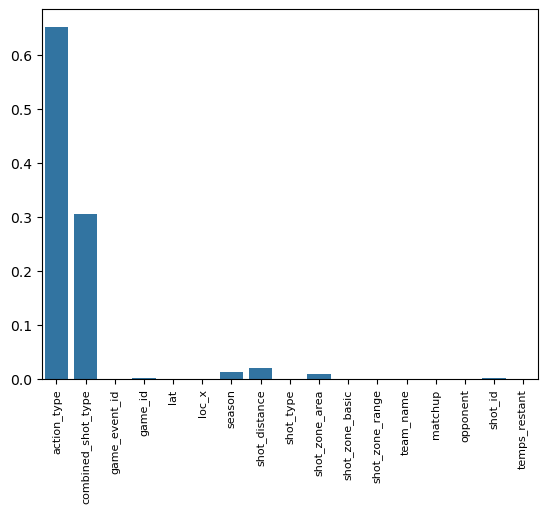

In [60]:
model_optimized = apprentissage("random_forest", X, y, feature_names, 0.02)

In [61]:
def generate_missing_shot_predictions(model_optimized, missing_shots_data, output_file):
    
    X_missing = process_label(missing_shots_data[["action_type", "combined_shot_type", "shot_distance"]])
    print(X_missing.shape)
    
    # Faire des prédictions de probabilité
    missing_predictions = model_optimized.predict_proba(X_missing)[:, 1]  # Probabilité de tir réussi
    
    # Créer un DataFrame avec les id de tir et les prédictions de probabilité
    result_df = pd.DataFrame({'shot_id': missing_shots_data['shot_id'], 'shot_made_flag': missing_predictions})
    
    # Sauvegarder le DataFrame dans un fichier CSV
    result_df.to_csv(output_file, index=False)

# Exemple d'utilisation :
# Supposons que vous ayez un DataFrame nommé missing_shots_data contenant les données de tir manquant
# et que vous avez déjà entraîné et optimisé votre modèle que vous avez nommé model_optimized

# Remplacez 'output_predictions.csv' par le chemin et le nom de fichier souhaité pour le résultat CSV
generate_missing_shot_predictions(model_optimized, missing_shots_data, '../Datasets/output_predictions.csv')


(5000, 3)


C:\Users\guilh\AppData\Local\Temp\ipykernel_18864\4066402416.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[numerical_cols] = scaler.fit_transform(X[numerical_cols])
C:\Users\guilh\AppData\Local\Temp\ipykernel_18864\4066402416.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = label_encoder.fit_transform(X[col])
C:\Users\guilh\AppData\Local\Temp\ipykernel_18864\4066402416.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i